## Описание проекта

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

In [1]:
# Импорт библиотек
import pandas as pd
from pymystem3 import Mystem
from collections import Counter
import seaborn as sns
from matplotlib import pyplot as plt

# Настройка отображения чисел по умолчанию
pd.set_option('display.float_format', '{:,.2f}'.format)

## Шаг 1. Откройте таблицу и изучите общую информацию о данных

In [2]:
df = pd.read_csv('/datasets/data.csv')
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,"-8,437.67",42,высшее,0,женат / замужем,0,F,сотрудник,0,"253,875.64",покупка жилья
1,1,"-4,024.80",36,среднее,1,женат / замужем,0,F,сотрудник,0,"112,080.01",приобретение автомобиля
2,0,"-5,623.42",33,Среднее,1,женат / замужем,0,M,сотрудник,0,"145,885.95",покупка жилья
3,3,"-4,124.75",32,среднее,1,женат / замужем,0,M,сотрудник,0,"267,628.55",дополнительное образование
4,0,"340,266.07",53,среднее,1,гражданский брак,1,F,пенсионер,0,"158,616.08",сыграть свадьбу


In [3]:
# Посмотрим общую информацию о столбцах
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


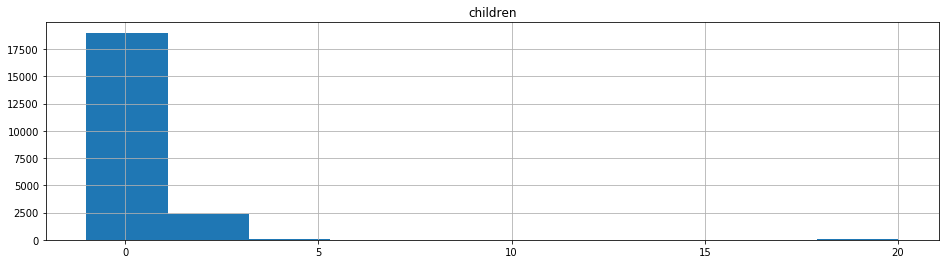

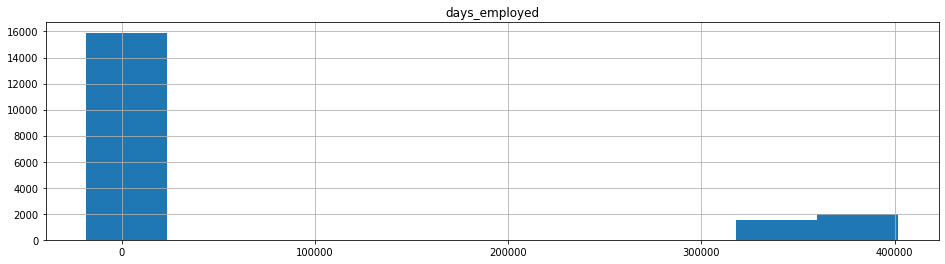

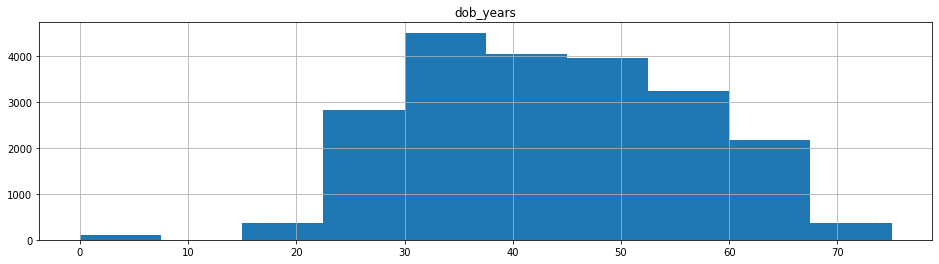

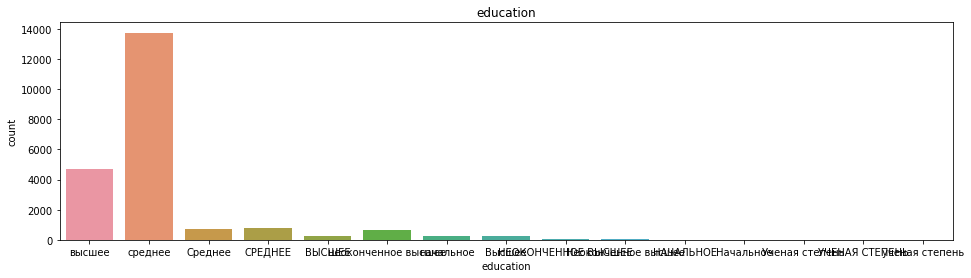

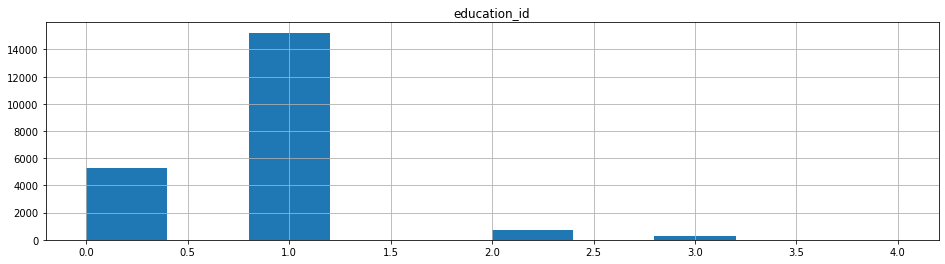

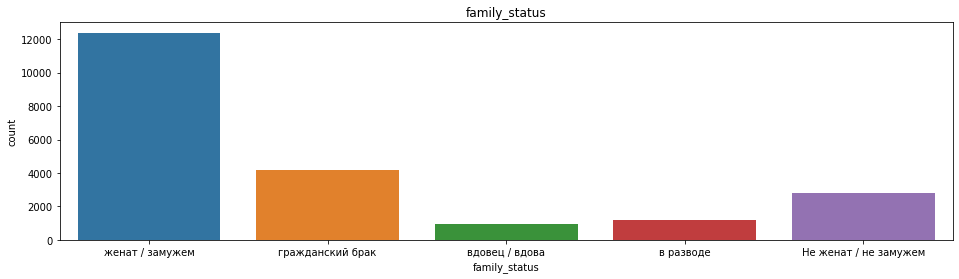

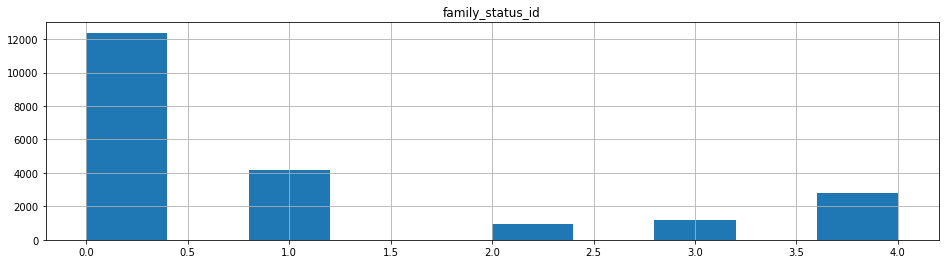

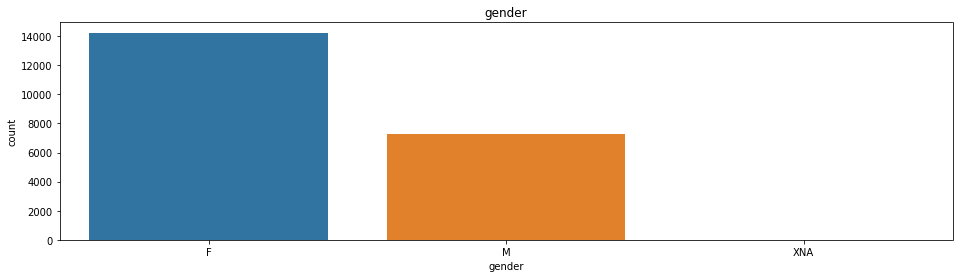

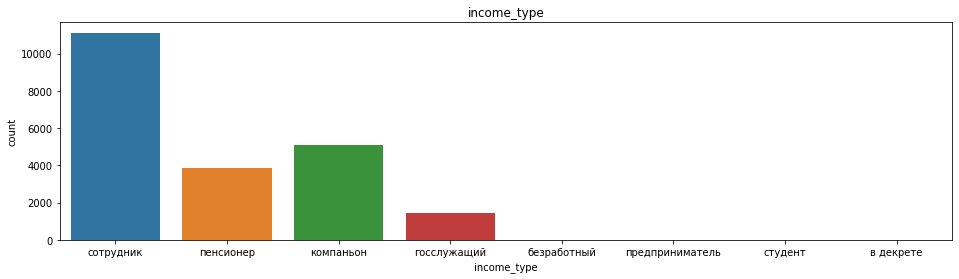

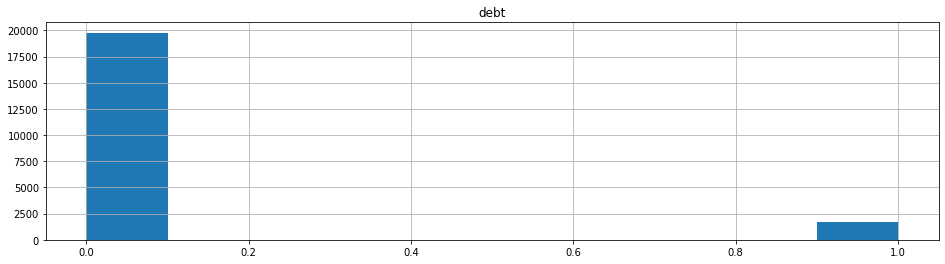

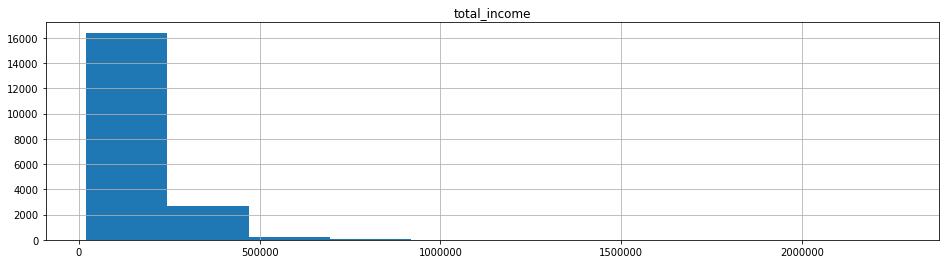

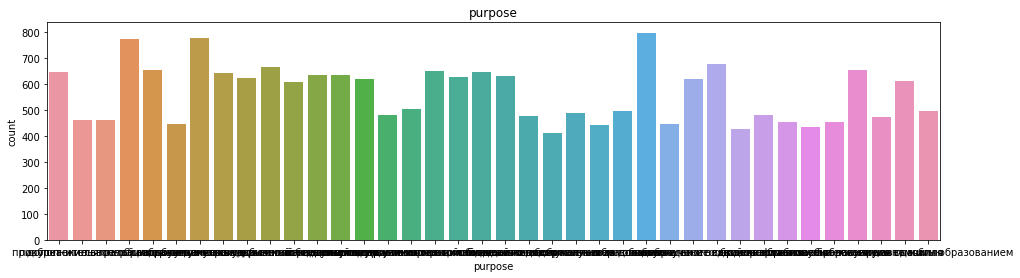

In [4]:
# Построиим гистограммы для каждого столбца
for col in df.columns:
    fig, ax = plt.subplots(figsize=(16, 4))  
    plt.title(col)
    if (df[col].dtypes == 'float') | (df[col].dtypes == 'int'):
        df[col].hist(ax=ax)        
    else:
        sns.countplot(df[col], ax=ax)

In [5]:
    # Проанализируем уникальные значения каждого столбца
    for col in df.columns:
        print(f'Уникальные значения столбца {col}:')
        print(df[col].unique())
        print(f'Количество вхождений каждого значения столбца {col}')
        print(df[col].value_counts())
        print('===================================================================================================================')

Уникальные значения столбца children:
[ 1  0  3  2 -1  4 20  5]
Количество вхождений каждого значения столбца children
 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64
Уникальные значения столбца days_employed:
[-8437.67302776 -4024.80375385 -5623.42261023 ... -2113.3468877
 -3112.4817052  -1984.50758853]
Количество вхождений каждого значения столбца days_employed
-986.93      1
-7,026.36    1
-4,236.27    1
-6,620.40    1
-1,238.56    1
            ..
-2,849.35    1
-5,619.33    1
-448.83      1
-1,687.04    1
-582.54      1
Name: days_employed, Length: 19351, dtype: int64
Уникальные значения столбца dob_years:
[42 36 33 32 53 27 43 50 35 41 40 65 54 56 26 48 24 21 57 67 28 63 62 47
 34 68 25 31 30 20 49 37 45 61 64 44 52 46 23 38 39 51  0 59 29 60 55 58
 71 22 73 66 69 19 72 70 74 75]
Количество вхождений каждого значения столбца dob_years
35    617
40    609
41    607
34    603
38    598
42    597
33

**Краткий итог предпросмотра данных**:

Столбец *children*: Существуют значения 20 и -1, которые, скорее всего возникли в результате ошибки при вводе данных, можно предположить, что число 20 в действительности соответсвует 2,а -1 соотвествует 1.

Столбец *days_employed*: Отрицательные значения. Причина - ошибка ввода данных на ПК. Помимо этого, стоит отметить наличие некоторых выбросов в диапазоне значений 300000 - 400000. Если перевести эти значения в годы, то получится стаж свыше 800 лет, что также не может отражать реальность и требует обработки. Причина - случайные нажатия.  

Столбец *dob_years*: Возраст 0 не отражает действительности. Однако число 0 встречается 101 раз в таблице, что может являться не ошибкой ввода данных, а пропуском из-за нежелания писать свой возраст.

Столбец *education*: Множество дубликатов из-за различных регистров написания.

Столбец *education_id*: Аномалий не замечено.

Столбец *family_status*: Привести написание к нижнему регистру.

Столбец *family_status_id*: Аномалий не замечено.

Столбец *gender*: Один раз попадается значение *xna*. Либо данный человек не относите себя ни к одному из двух гендеров, либо ошибка, возникшая при переносе и копировании данных.

Столбец *income_type*: Аномалий не замечено.

Столбец *debt*: Аномалий не замечено.

Столбец *total_income*: Неравномерно распределены значения, есть небольшие выбросы со значениями больше 1М. Имеет смысл ввести новый столбец с подразделением людей по уровню дохода. В первом приближении можно выделить следующие диапазоны ЗП: 1) <=500К; 2) >500K & <=1M; 3) >1M.

Столбец *purpose*: Много различных по написанию, но схожих по смыслу значений..

## Шаг 2. Предобработка данных
1. определите и заполните пропущенные значения: 

    - опишите, какие пропущенные значения вы обнаружили; 
    
    - приведите возможные причины появления пропусков в данных; 
    
    - объясните, по какому принципу заполнены пропуски;

Сначала разберемся с некорректными значениями.

**Столбец *children***

In [6]:
#Заменим неправильные значения на правильные
df.loc[df['children'] == 20, 'children'] = 2
df.loc[df['children'] == -1, 'children'] = 1
#Проверим значения
df['children'].unique()

array([1, 0, 3, 2, 4, 5])

**Столбец *days_employed***

In [7]:
# Домножим отрицательные значения на -1
df.loc[df['days_employed'] < 0, 'days_employed'] = -1 * df['days_employed']
# Проверим на наличе отрицательных чисел
df['days_employed'].describe()

count    19,351.00
mean     66,914.73
std     139,030.88
min          24.14
25%         927.01
50%       2,194.22
75%       5,537.88
max     401,755.40
Name: days_employed, dtype: float64

Стаж свыше 300000 дней соответсвует 800 и более годам работы, скорее всего случайно нажали 2 лишние цифры, чтобы получить реальные цифры можно без отстака поделить некорректные значения на 100

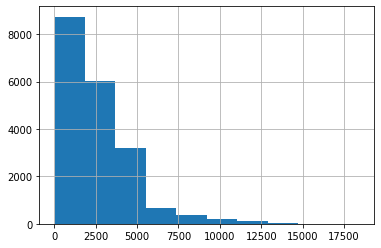

In [8]:
# Заменим значения больше 300000 на результат целочисленного деления на 100
df.loc[df['days_employed'] > 300000, 'days_employed'] = df['days_employed'] // 100
# Проверим значения
df['days_employed'].hist()

In [9]:
# Проверим значения
df['days_employed'].describe()

count   19,351.00
mean     2,583.83
std      2,148.99
min         24.14
25%        927.01
50%      2,194.22
75%      3,658.22
max     18,388.95
Name: days_employed, dtype: float64

**Столбец *dob_years***

In [11]:
# Подсчитаем долю значений равных 0
print('Доля некорректных значений {:.2%}'.format(df[df['dob_years'] == 0]['dob_years'].count() / df.shape[0]))

Доля некорректных значений 0.47%


Доля меньше 0,5%, поэтому можно удалить такие значения, чтобы не создавать ложные данные и прогнозы

In [12]:
# Удалим все строки с нулевым значением
df.drop(df[df['dob_years'] == 0].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [13]:
# Проверка
df['dob_years'].unique()

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51, 59, 29, 60, 55, 58, 71, 22, 73, 66,
       69, 19, 72, 70, 74, 75])

**Столбец *gender***

In [14]:
df['gender'].value_counts()

F      14164
M       7259
XNA        1
Name: gender, dtype: int64

Так как только одно некорректное значени в столбце, то его можно удалить.

In [15]:
# Удалим строку с неправильным значением
df.drop(df[df.gender == 'XNA'].index, inplace=True)
df.reset_index(drop=True, inplace=True)
# Проверим значения
df['gender'].value_counts()

F    14164
M     7259
Name: gender, dtype: int64

**Обработка пропусков**

In [16]:
# Подсчитаем количество пропусков
print(df.isnull().sum())

children               0
days_employed       2164
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2164
purpose                0
dtype: int64


In [17]:
# Подсчитаем долю пропусков
print(df.isnull().mean())

children           0.00
days_employed      0.10
dob_years          0.00
education          0.00
education_id       0.00
family_status      0.00
family_status_id   0.00
gender             0.00
income_type        0.00
debt               0.00
total_income       0.10
purpose            0.00
dtype: float64


Пропуски в столбцах *days_employed* и *total_income* составляют 10%. В случае с первым столбцом пропуски могут быть вызваны тем, что люди или не помнят точную дату начала работы (или уволнения), или не хотят указывать на то, что они безработные. В случае со столбцом про доход пропуски могут быть вызваны тем, что клиенты или не имеют дохода постоянного, или считают, что данная информация личная. 

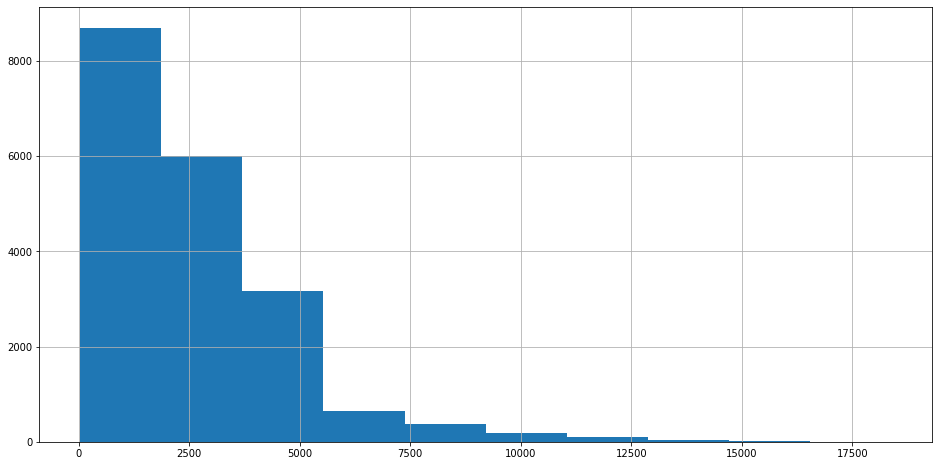

In [18]:
# Посмотрим на гистограммы обрабоатываемых величин
plt.figure(figsize=(16,8))
df['days_employed'].hist()

Для заполнения пропусков в столбце *days_employed* только среднее не подходит, так как данные не равномерны и большинство значений находятся до 5000. Логично, что трудовой стаж должен коррелировать с возрастом. Можно выделить три возрастные группы: 1) до 25; 2) от 25 до 60 и 3) от 60 и заполнить пропуски средним в зависимости от возраста.

In [19]:
# Заполним пропуски для тех, кто младше 25
mean = df.loc[df['dob_years'] <= 25, 'days_employed'].mean()
df.loc[df['dob_years'] <= 25, 'days_employed'] = df.loc[df['dob_years'] <= 25, 'days_employed'].fillna(mean)
print(f'Средний стаж для тех, кто старше 25: {mean:.0f} дней')

# Заполним пропуски для тех, кто старше 25, но младше 60
mean = df.loc[(df['dob_years'] > 25) & (df['dob_years'] <= 60), 'days_employed'].mean()
df.loc[(df['dob_years'] > 25) & (df['dob_years'] <= 60), 'days_employed'] = df.loc[(df['dob_years'] > 25) & (df['dob_years'] <= 60), 'days_employed'].fillna(mean)
print(f'Средний стаж для тех, кто старше 25, но младше 60: {mean:.0f} дней')

# Заполним пропуски для тех, кто старше 60
mean = df.loc[df['dob_years'] > 60, 'days_employed'].mean()
df.loc[df['dob_years'] > 60, 'days_employed'] = df.loc[df['dob_years'] > 60, 'days_employed'].fillna(mean)
print(f'Средний стаж для тех, кто старше 60: {mean:.0f} дней')

Средний стаж для тех, кто старше 25: 925 дней
Средний стаж для тех, кто старше 25, но младше 60: 2567 дней
Средний стаж для тех, кто старше 60: 3698 дней


Посмотрим на значения столбца *total_income*

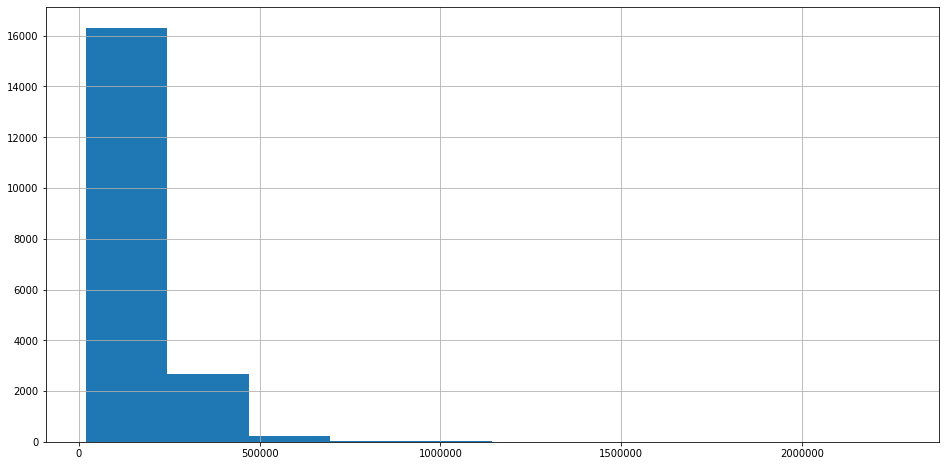

In [20]:
# Построим гистограмму
plt.figure(figsize=(16,8))
df['total_income'].hist()

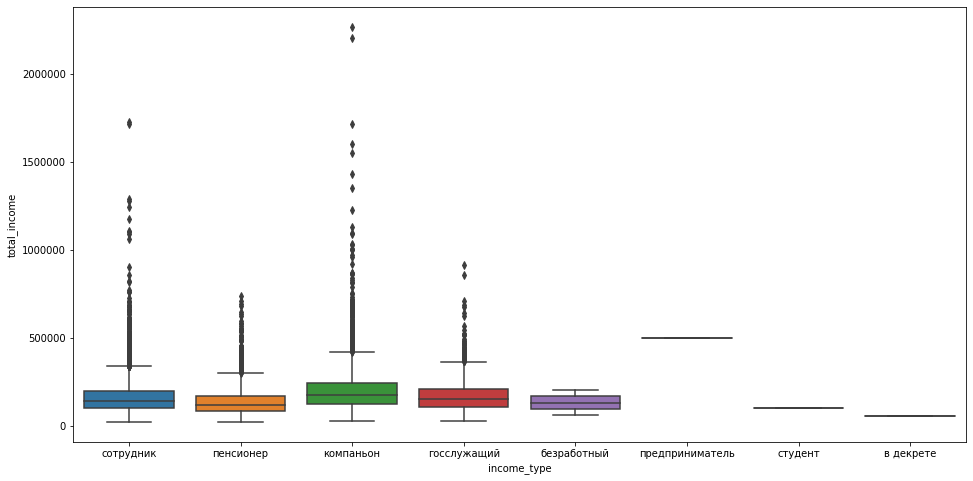

In [21]:
# Посмотрим зависимость уровня дохода от должности
plt.figure(figsize=(16,8))
sns.boxplot(x='income_type', y='total_income', data=df)

По графикам видно, что моды значений дохода для разных должностей похожи. Однако, должности "компаньон" и "сотрудник" имеют наиболее значимые выбросы. Имеет смысл заполянть пропуски медианой в зависимости от должности.

In [22]:
# Рассчитаем для каждой должности медиану и заполним пропуски
for position in df['income_type'].unique():
    med = df.loc[df['income_type'] == position, 'total_income'].median()
    df.loc[df['income_type'] == position, 'total_income'] = df.loc[df['income_type'] == position, 'total_income'].fillna(med)

In [23]:
# Подсчитаем количество пропусков
print(df.isnull().sum())

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64


2. замените вещественный тип данных на целочисленный:

    - поясните, как выбирали метод для изменения типа данных;

Сначала выделил все стольбцы с нужным типом данных. Затем с помощью метода astype() измених их тип и перезаписал старые слотбцы, чтобы сохранить результат.

In [24]:
df.loc[:,df.dtypes == 'float64'] = df.loc[:,df.dtypes == 'float64'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21423 entries, 0 to 21422
Data columns (total 12 columns):
children            21423 non-null int64
days_employed       21423 non-null int64
dob_years           21423 non-null int64
education           21423 non-null object
education_id        21423 non-null int64
family_status       21423 non-null object
family_status_id    21423 non-null int64
gender              21423 non-null object
income_type         21423 non-null object
debt                21423 non-null int64
total_income        21423 non-null int64
purpose             21423 non-null object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


3. удалите дубликаты:
    - поясните, как выбирали метод для поиска и удаления дубликатов в данных;
    - приведите возможные причины появления дубликатов;

In [25]:
# Приведем все категориальные признаки к одному виду (нижний регистр)
for col in df.columns:
    if df[col].dtypes == 'O':
        df[col] = df[col].str.lower()
        # Проверим на грамматические ошибки
        print(df[col].unique())

['высшее' 'среднее' 'неоконченное высшее' 'начальное' 'ученая степень']
['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'не женат / не замужем']
['f' 'm']
['сотрудник' 'пенсионер' 'компаньон' 'госслужащий' 'безработный'
 'предприниматель' 'студент' 'в декрете']
['покупка жилья' 'приобретение автомобиля' 'дополнительное образование'
 'сыграть свадьбу' 'операции с жильем' 'образование'
 'на проведение свадьбы' 'покупка жилья для семьи' 'покупка недвижимости'
 'покупка коммерческой недвижимости' 'покупка жилой недвижимости'
 'строительство собственной недвижимости' 'недвижимость'
 'строительство недвижимости' 'на покупку подержанного автомобиля'
 'на покупку своего автомобиля' 'операции с коммерческой недвижимостью'
 'строительство жилой недвижимости' 'жилье'
 'операции со своей недвижимостью' 'автомобили' 'заняться образованием'
 'сделка с подержанным автомобилем' 'получение образования' 'автомобиль'
 'свадьба' 'получение дополнительного образования' 'покупка своего ж

Поиск дубликатов выполнил с помощью метода duplicated(), а удаление с помощью метода drop_duplicates(). Дубликаты могли появится из-за ошибки повторного ввода данных в систему.

In [26]:
# Подсчитаем количество простых дубликатов
print(df.duplicated().sum())

71


In [27]:
# Удалим все дубликаты
df = df.drop_duplicates().reset_index(drop=True)
# Проверим, что все сработало
print(df.duplicated().sum())

0


4. выделите леммы в значениях столбца с целями получения кредита:
    - опишите, как вы проводили лемматизацию целей кредита;

In [28]:
#Конвертируем список уникальных значений столбца purpose в строку, разделив цели запятой, 
# и проведем лемматизацию
m = Mystem()
purposes = ','.join(df['purpose'].unique())
print(purposes)
print('=============================================================================================')
lemmas = m.lemmatize(purposes)
print(lemmas)

покупка жилья,приобретение автомобиля,дополнительное образование,сыграть свадьбу,операции с жильем,образование,на проведение свадьбы,покупка жилья для семьи,покупка недвижимости,покупка коммерческой недвижимости,покупка жилой недвижимости,строительство собственной недвижимости,недвижимость,строительство недвижимости,на покупку подержанного автомобиля,на покупку своего автомобиля,операции с коммерческой недвижимостью,строительство жилой недвижимости,жилье,операции со своей недвижимостью,автомобили,заняться образованием,сделка с подержанным автомобилем,получение образования,автомобиль,свадьба,получение дополнительного образования,покупка своего жилья,операции с недвижимостью,получение высшего образования,свой автомобиль,сделка с автомобилем,профильное образование,высшее образование,покупка жилья для сдачи,на покупку автомобиля,ремонт жилью,заняться высшим образованием
['покупка', ' ', 'жилье', ',', 'приобретение', ' ', 'автомобиль', ',', 'дополнительный', ' ', 'образование', ',', 'сыграт

In [29]:
#Подсчитаем количество вхождений каждого слова в список с леммами
print(Counter(lemmas))

Counter({' ': 59, ',': 37, 'покупка': 10, 'недвижимость': 10, 'автомобиль': 9, 'образование': 9, 'жилье': 7, 'с': 5, 'операция': 4, 'на': 4, 'свой': 4, 'свадьба': 3, 'строительство': 3, 'получение': 3, 'высокий': 3, 'дополнительный': 2, 'для': 2, 'коммерческий': 2, 'жилой': 2, 'подержать': 2, 'заниматься': 2, 'сделка': 2, 'приобретение': 1, 'сыграть': 1, 'проведение': 1, 'семья': 1, 'собственный': 1, 'со': 1, 'профильный': 1, 'сдача': 1, 'ремонт': 1, '\n': 1})


Порядок лемматизации следующий: сначала я собрал все уникальные значения столбца *purpose* и конвертировал список значений в строку, разделив элементы запятой; затем я использовал метод *lemmatize()* из класса *Mystem* и получил спесок лемм для каждого слова; в конце подсчитал количество вхождений каждого слова, используя контейнер *Counter*. 

По результатам анализа можно выявить четыре группы: 1) связанные с операциями с недвижимостью или жильем; 2) с операциями с автомобилем; 3) с получением образование; 4) с организацией свадьбы.

Реализуем функцию, которая будет заменять цели их леммами

In [30]:
#Заменим цели для кредита на полученные леммы
#Напишем функцию, которая на вход принимает столбец *purpose*, а на выходе возвращает одну из четырех групп
def get_purpose(purpose):
    lemmas = m.lemmatize(purpose)
    if ('недвижимость' in lemmas) or ('жилье' in lemmas):
        return 'недвижимость'
    elif 'автомобиль' in lemmas:
        return 'автомобиль'
    elif 'свадьба' in lemmas:
        return 'свадьба'
    else:
        return 'образование'
    
    
#Применим написанную функцию и заменим цели полученными леммами
df['purpose'] = df['purpose'].apply(get_purpose)
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,f,сотрудник,0,253875,недвижимость
1,1,4024,36,среднее,1,женат / замужем,0,f,сотрудник,0,112080,автомобиль
2,0,5623,33,среднее,1,женат / замужем,0,m,сотрудник,0,145885,недвижимость
3,3,4124,32,среднее,1,женат / замужем,0,m,сотрудник,0,267628,образование
4,0,3402,53,среднее,1,гражданский брак,1,f,пенсионер,0,158616,свадьба
5,0,926,27,высшее,0,гражданский брак,1,m,компаньон,0,255763,недвижимость
6,0,2879,43,высшее,0,женат / замужем,0,f,компаньон,0,240525,недвижимость
7,0,152,50,среднее,1,женат / замужем,0,m,сотрудник,0,135823,образование
8,2,6929,35,высшее,0,гражданский брак,1,f,сотрудник,0,95856,свадьба
9,0,2188,41,среднее,1,женат / замужем,0,m,сотрудник,0,144425,недвижимость


In [31]:
# Проверим уникальные значения столюца purpose
df['purpose'].unique()

array(['недвижимость', 'автомобиль', 'образование', 'свадьба'],
      dtype=object)

5. категоризируйте данные:
    - перечислите, какие «словари» вы выделили для этого набора данных, и объясните, почему.

In [33]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,f,сотрудник,0,253875,недвижимость
1,1,4024,36,среднее,1,женат / замужем,0,f,сотрудник,0,112080,автомобиль
2,0,5623,33,среднее,1,женат / замужем,0,m,сотрудник,0,145885,недвижимость
3,3,4124,32,среднее,1,женат / замужем,0,m,сотрудник,0,267628,образование
4,0,3402,53,среднее,1,гражданский брак,1,f,пенсионер,0,158616,свадьба


Можно выделить следующие словари ['family_status', 'family_status_id'] и ['education', 'education_id'], помимо этого, чтобы уменьшить размер таблицы можно составить словарь для столбцов *income_type* и *purpose*, заменив буквенные обозначения дискретынми численными. Дополнительно можно заменить численные значения в столбцах *dob_years* и *total_income* на возрастные и доходные группы для упрощения анализа результатов.

Заменим непрерывные значения в столбцах *dob_years* и *total_income* на возрастные и доходные группы для упрощения анализа результатов.

In [34]:
# Напишем функцию, которая в соотвествии возрасту возвращет группу
def get_age_group(age):
    if age <= 25:
        return 'молодой'
    if age > 60:
        return 'пенсионер'
    return 'взрослый'

# Применим функции и создадим новый столбец
df['age_group'] = df['dob_years'].apply(get_age_group)

In [35]:
# Напишем функцию, которая в соотвествии заработку возвращет группу
def get_age_group(income):
    if income <= 500000:
        return '<=500K'
    if income > 1000000:
        return '>1M'
    return '>500K & <=1M'

# Применим функции и создадим новый столбец
df['income_group'] = df['total_income'].apply(get_age_group)

In [36]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group,income_group
0,1,8437,42,высшее,0,женат / замужем,0,f,сотрудник,0,253875,недвижимость,взрослый,<=500K
1,1,4024,36,среднее,1,женат / замужем,0,f,сотрудник,0,112080,автомобиль,взрослый,<=500K
2,0,5623,33,среднее,1,женат / замужем,0,m,сотрудник,0,145885,недвижимость,взрослый,<=500K
3,3,4124,32,среднее,1,женат / замужем,0,m,сотрудник,0,267628,образование,взрослый,<=500K
4,0,3402,53,среднее,1,гражданский брак,1,f,пенсионер,0,158616,свадьба,взрослый,<=500K


## Шаг 3. Ответьте на вопросы

**Есть ли зависимость между наличием детей и возвратом кредита в срок?**

In [37]:
#Подсчитаем долю людей с детьми и без задолжностей 
people_without_children = df[(df['children'] == 0) & (df['debt'] == 0)].debt.count() \
/ df[df['children'] == 0].debt.count()
print(f'Доля людей без детей без задолжности по кредиту: {people_without_children:.2%}')
#Подсчитаем долю людей без детей и без задолжностей
people_with_children = df[(df['children'] != 0) & (df['debt'] == 0)].debt.count() \
/ df[df['children'] != 0].debt.count()
print(f'Доля людей с детьми без задолжности по кредиту: {people_with_children:.2%}')

Доля людей без детей без задолжности по кредиту: 92.45%
Доля людей с детьми без задолжности по кредиту: 90.79%


Оценим как количество детей влияет на возврат кредитов

In [38]:
# Создадим список значений семейных положений
numbers = sorted(df['children'].unique())
# Для каждого варианта посчитаем долю людей без задолжности 
for number in numbers:
    ratio = df[(df['children'] == number) & (df['debt'] == 0)].debt.count() \
    / df[df['children'] == number].debt.count()
    print(f'Доля людей с {number} детьми и без задолжности равна {ratio:.2%}')
    print()

Доля людей с 0 детьми и без задолжности равна 92.45%

Доля людей с 1 детьми и без задолжности равна 90.87%

Доля людей с 2 детьми и без задолжности равна 90.44%

Доля людей с 3 детьми и без задолжности равна 91.77%

Доля людей с 4 детьми и без задолжности равна 90.24%

Доля людей с 5 детьми и без задолжности равна 100.00%



<div class="alert alert-warning">
<b>Комментарий ревьюера V2:</b>
    
- Хорошоо, только у тебя значения очень близки друг другу, попробуй сделать выделение хотябы до 2 знаков после запятой.
</div>

**Вывод: наличие детей не влияет на возникновение задолжностей**

**Есть ли зависимость между семейным положением и возвратом кредита в срок?**

In [39]:
# Создадим список значений семейных положений
family_status = df['family_status'].unique()
# Для каждого варианта посчитаем долю людей без задолжности 
for status in family_status:
    ratio = df[(df['family_status'] == status) & (df['debt'] == 0)].debt.count() \
    / df[df['family_status'] == status].debt.count()
    print(f'Доля людей со статусом "{status}" и без задолжности равна {ratio:.2%}')
    print()

Доля людей со статусом "женат / замужем" и без задолжности равна 92.46%

Доля людей со статусом "гражданский брак" и без задолжности равна 90.65%

Доля людей со статусом "вдовец / вдова" и без задолжности равна 93.50%

Доля людей со статусом "в разводе" и без задолжности равна 92.83%

Доля людей со статусом "не женат / не замужем" и без задолжности равна 90.23%



**Вывод: В целом значения близки. Однако, реже всех возвращают кредит те, кто никода не был в браке. Зтем идут люди, которые состоят в обычном или гражданском браке, прирост в возвращаемости кредитов может быть вызван финансовой помощью со стороны супруга/супруги и обчщим бюджетом. Наиболее надежны люди в разводе и вдовы/вдовцы. Их высокая платежеспособность вероятнее всего вызвана наличием аллиментов или наследства от почившего супруга.**

**Есть ли зависимость между уровнем дохода и возвратом кредита в срок?**

In [40]:
# Рассмотрим процент возврата кредита без задолженностей для каждой группы доходности
for group in df['income_group'].unique():
    ratio = df[(df['income_group'] == group) & (df['debt'] == 0)].debt.count() / df[df['income_group'] == group].debt.count()
    print(f'Доля людей с ЗП {group} и без задолжности по кредиту: {ratio:.2%}')

Доля людей с ЗП <=500K и без задолжности по кредиту: 91.86%
Доля людей с ЗП >500K & <=1M и без задолжности по кредиту: 93.91%
Доля людей с ЗП >1M и без задолжности по кредиту: 92.00%


**Вывод: Самые надежные клиенты - люди с уровенем дохода между 500К и 1М. Может быть, такие люди правильно расчитывают свои возможности и берут кредит на то, что им под силу**

**Как разные цели кредита влияют на его возврат в срок?**

In [41]:
# Создадим список значений целей для кредита
purposes = df['purpose'].unique()
# Для каждого варианта посчитаем долю людей без задолжности 
for purpose in purposes:
    ratio = df[(df['purpose'] == purpose) & (df['debt'] == 0)].debt.count() \
    / df[df['purpose'] == purpose].debt.count()
    print(f'Доля людей с целью "{purpose}" и без задолженности равна {ratio:.2%}')
    print()

Доля людей с целью "недвижимость" и без задолженности равна 92.76%

Доля людей с целью "автомобиль" и без задолженности равна 90.66%

Доля людей с целью "образование" и без задолженности равна 90.74%

Доля людей с целью "свадьба" и без задолженности равна 92.03%



**Вывод: Меньше всего задолжностей по кредитам на недвижимость. Это может быть вызвано тем, что цены на жилье высоки и выплачивать придеться достаточно долго, поэтому люди серьезно подходят в этому вопросу и грамотно оценивают свои возможности. Низкие задолженности по свадьбам являются результатом объединения бюджетов мужа и жены, а также финансовым приливом за счет подарков на свадьбу.Что касается цели "образование", люди обычно идут учиться, чтобы получить более оплачиваемую работу. Поэтому задолженности вызваны тем, что люди пока не нашли лучшую работу или из-за нехватки времени у них возникли проблемы с текущей. Касательно кредитов на автомобиль, задолженности вызваны желанием купить машину по-дороже и современнее, при этом некоторые не могут рассчитать свои финансовые возможности.**

## Шаг 4 Напишите общий вывод

В данном проекте были реализованы различные методы для обработки ошибоки дубликатов данных, была проведена категоризация данных и лемматизация целей взятия кредита. Перечисленные действия направлены на улучшения качества данных и упрощения анализа данных.

По результату анализа из полученных данных следуют следующие утверждения:

1) Наличие детей не влияет на возврат кредита;

2) Лучше всех возвращают кредиты те, кто был в браке или потерял супруга. С другой стороны, одинокие люди чаще задерживают выплаты по кредиту;

3) Надежнее люди с доходом от 500К до 1М;

4) Те, кто берут кредиты для свадьбы или недвижимости, более платежеспособные, чем те, кто берут кредит на обучение и автомобиль